# Adaptive RAG

- Author: [Yoonji Oh](https://github.com/samdaseuss)
- Design: [LeeYuChul](https://github.com/LeeYuChul)
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

This tutorial introduces Adaptive RAG, which finds information and generates answers in a smarter way. Adaptive RAG is a system that analyzes the nature of questions using AI, selects the most appropriate method such as web search or internal document search to find information, and creates the best possible answer by trying different methods when necessary. In this tutorial, we implement routing between web search and internal document search using LangGraph.

The purpose of this tutorial is to help users understand the concept of Adaptive RAG and learn how to implement it using LangGraph. Through this, users can perform web searches for questions related to recent events and utilize internal document search with self-correcting capabilities for questions related to indexed content.

**What We Will Learn** 

* **Preparing Data (Create Index)**  
  Convert documents into a format our system can understand and load them
  
* **Using AI (LLMs)**  
  Use AI to analyze questions and evaluate how good our retrieved documents are
  
* **Building Web Search Tool (Web Search Tool)**  
  Set up tools to search for up-to-date information on the web
  
* **Designing System Structure (Construct the Graph)**  
  Design how our system will work and in what order
  
* **Completing the System (Compile Graph)**  
  Turn our design into a working system
  
* **Testing in Action (Use Graph)**  
  Run our completed system and verify it works properly


### Table of Contents

- [Overview](#overview)
- [Environement Setup](#environment-setup)
- [Why Adaptive RAG?](#why-adaptive-rag)
- [Creating a Basic PDF-based Retrieval Chain](#creating-a-basic-pdf-based-retrieval-chain)
- [Query Routing and Document Evaluation](#query-routing-and-document-evaluation)
- [Tools](#tools)
- [Graph Construction](#graph-construction) 
- [Define Graph Flows](#define-graph-flows)
- [Graph Utilization](#graph-utilization)

### References

- [LangChain: Query Construction](https://blog.langchain.dev/query-construction/)
- [LangGraph: Self-Reflective RAG](https://blog.langchain.dev/agentic-rag-with-langgraph/)
- [Adaptive-RAG: Learning to Adapt Retrieval-Augmented Large Language Models through Question Complexity](https://arxiv.org/abs/2403.14403)
----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain",
        "langchain_core",
        "langchain_community",
        "langchain_openai",
    ],
    verbose=False,
    upgrade=False,
)


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Adaptive-RAG"
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[NOTE] 

This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Why Adaptive RAG?
Let's say an astrophysicist asks these questions to an AI chatbot:

1. "Sagittarius A* just released an unprecedented burst of X-rays - why is this significant?"
2. "Can you analyze how Sagittarius A*'s X-ray emission patterns have changed over the past 5 years?"

While a conventional RAG system would approach information retrieval the same way every time, Adaptive RAG recognizes the different nature of these questions and responds accordingly:

* **Current X-ray burst** → Search the web for real-time observations and urgent analysis from scientists
* **X-ray emission patterns** → Analyze 5 years of observational records from our astrophysics database
* Ability to self-correct if the answer is inaccurate

**Adaptive RAG** is a **RAG** strategy that combines (1) **query analysis** and (2) **Self-Reflective RAG**.

The paper "Adaptive-RAG: Learning to Adapt Retrieval-Augmented Large Language Models through Question Complexity" performs routing through query analysis in the following ways:
* `No Retrieval` 
* `Single-shot RAG` 
* `Iterative RAG` 

We implement this using LangGraph.
In this implementation, we perform the following routing:
* **Web Search** : Used for questions about recent events
* **Self-correcting RAG** : Used for questions about indexed content

<div style="text-align: center;">
    <img src="./assets/07-langgraph-adaptive-rag-01.png" alt="Image Description" width="500">
</div>

## Creating a Basic PDF-based Retrieval Chain
Here we create a Retrieval Chain based on PDF documents. This is the most basic structure of a Retrieval Chain.
Note that in LangGraph, we create the Retriever and Chain separately. This allows us to process each node in detail.

**Note**
* Since this was covered in the previous tutorial, we'll skip the detailed explanations.

In [5]:
%pip install -qU langchain langchain-chroma


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
file_path = 'data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf'

In [7]:
from enum import Enum

class LLMs(Enum):
    GPT4o_MINI = "gpt-4o-mini"
    GPT4o = "gpt-4o"
    GPT4 = GPT4o_MINI

    O1_PREVIEW = "o1-preview"
    O1_MINI = "o1-mini"
    O1 = O1_MINI

    CLAUDE_SONNET = "claude-3-5-sonnet-20241022"
    CLAUDE_HAIKU = "claude-3-5-haiku-20241022"
    CLAUDE = CLAUDE_SONNET

    UPSTAGE_SOLAR_MINI = "solar-mini"
    UPSTAGE_SOLAR_PRO = "solar-pro"
    UPSTAGE = UPSTAGE_SOLAR_PRO

def get_model_name(model: LLMs) -> str:
    """
    :type model: LLMs
    :rtype: str
    """
    try:
        # Return the final value if the value is an Enum member
        current_value = model.value
        while isinstance(current_value, Enum):
            current_value = current_value.value
        return current_value
    except AttributeError:
        return None

In [8]:
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_chroma import Chroma
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI

# Create document loader
loader = PDFPlumberLoader(file_path)

# Load documents
documents = loader.load()

# Create embeddings
embeddings = OpenAIEmbeddings()

# Create vector store
vectorstore = Chroma.from_documents(documents, embeddings)

# Create retriever
pdf_retriever = vectorstore.as_retriever()

# Get the latest LLM model name
MODEL_NAME = get_model_name(LLMs.GPT4o)

# Initialize LLM and generate structured output through function calling
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

prompt = ChatPromptTemplate.from_template("""Answer the following question based on the provided context:\n\nContext: {context}\nQuestion: {question}\n\nAnswer the question based only on the above context.""")

# Create document chain
document_chain = create_stuff_documents_chain(llm, prompt)

# Create retrieval chain
chain = (
    {"context": pdf_retriever, "question": RunnablePassthrough()} 
    | document_chain
)

## Query Routing and Document Evaluation
The **LLMs** stage performs **query routing** and **document evaluation** . This process is a crucial part of **Adaptive RAG** , contributing to efficient information retrieval and generation.

* **Query Routing** : Analyzes user queries to route them to appropriate information sources. This enables setting the optimal search path based on the query's purpose.
* **Document Evaluation** : Assesses the quality and relevance of retrieved documents to enhance the accuracy of final results. This process is essential for maximizing the performance of **LLMs** .

This stage supports the core functionality of **Adaptive RAG** and aims to provide accurate and reliable information.

In [9]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Data model for routing user queries to the most relevant data source
class RouteQuery(BaseModel):
   """Route a user query to the most relevant datasource."""

   # Literal type field for selecting data source
   datasource: Literal["vectorstore", "web_search"] = Field(
       ...,
       description="Given a user question choose to route it to web search or a vectorstore.",
   )

structured_llm_router = llm.with_structured_output(RouteQuery)

# Create prompt template containing system message and user question
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to "A European Approach to Artificial Intelligence - A Policy Perspective".
Use the vectorstore for questions on European AI policy and regulations. Otherwise, use web-search."""

# Create prompt template for routing
route_prompt = ChatPromptTemplate(
   [
       ("system", system),
       ("human", "{question}"),
   ]
)

# Combine prompt template and structured LLM router to create question router
question_router = route_prompt | structured_llm_router

Now let's pass questions to our `rag_chain` to generate responses.

In [10]:
# Question that needs document search
question_router.invoke({"question": "According to the European approach, what are the current limitations of AI applications in healthcare settings?According to the European approach, what are the current limitations of AI applications in healthcare settings?"})

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Forbidden"}')


RouteQuery(datasource='vectorstore')

In [11]:
# Question that needs web search
question_router.invoke({"question": "Who are the confirmed headliners for Austin City Limits Music Festival 2025?"})

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Forbidden"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Forbidden"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Forbidden"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: htt

RouteQuery(datasource='web_search')

### Retrieval Grader

In [12]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# Define data model for document evaluation
class GradeDocuments(BaseModel):
   """Binary score for relevance check on retrieved documents."""

   binary_score: str = Field(
       description="Documents are relevant to the question, 'yes' or 'no'"
   )

# Initialize LLM and generate structured output through function calling
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Create prompt template containing system message and user question
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
   If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
   It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
   Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate(
   [
       ("system", system),
       ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
   ]
)

# Create document retrieval grader
retrieval_grader = grade_prompt | structured_llm_grader

Using the created `retrieval_grader` to evaluate the document retrieval results.

In [13]:
# Set user question
question = "According to the European approach, what are the current limitations of AI applications in healthcare settings?According to the European approach, what are the current limitations of AI applications in healthcare settings?"

# Retrieve relevant documents for the question
docs = pdf_retriever.invoke(question)

# Get content from retrieved document
retrieved_doc = docs[0].page_content

# Print evaluation results
print(retrieval_grader.invoke({"question": question, "document": retrieved_doc}))

binary_score='yes'


### Creating RAG Chain for Answer Generation

In [14]:
import yaml
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.prompts.prompt import PromptTemplate

# Get prompt from LangChain Hub (RAG prompt can be freely modified)
def load_prompt_template(file_path: str) -> dict:
    with open(file_path, 'r', encoding='utf-8') as file:
        template_data = yaml.safe_load(file)
    return template_data

template = load_prompt_template('rag/prompts/rag-prompt.yaml')["template"]

# Use PromptTemplate object instead of string
prompt = PromptTemplate(
    template=template,
    input_variables=["question", "context"]
)

# Initialize LLM
llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)

# Document formatting function
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )

# Create RAG chain
rag_chain = prompt | llm | StrOutputParser()

Now we'll use our `rag_chain` to generate responses by passing questions to it. 

In [15]:
# Generate answer by passing question to RAG chain
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

AI applications in healthcare settings in Europe face several limitations: 

1. **Data Privacy and Trust**: There are concerns about data privacy and patient trust, as AI tools need to demonstrate that they handle data privacy with care beyond GDPR requirements.

2. **Data Governance**: AI tools must prove a clear return on investment, and there is a need for a common language and understanding between data experts and healthcare professionals.

3. **Organizational and Skill Challenges**: There is a need for upskilling or reskilling healthcare practitioners to understand AI's potential, and specific healthcare training should be provided to data scientists.

4. **Regulatory Harmonization**: New AI regulations need to be harmonized with existing regulations, such as medical device regulations, to avoid fragmentation.

5. **Fragmentation of Healthcare Systems**: Fragmented healthcare systems and standards across EU Member States pose challenges for data access and interoperability.

6. *

### Adding Hallucination Checker for Responses

In [16]:
# Define data model for hallucination check
class GradeHallucinations(BaseModel):
   """Binary score for hallucination present in generation answer."""
   binary_score: str = Field(
       description="Answer is grounded in the facts, 'yes' or 'no'"
   )

# Initialize LLM with function calling
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Set up prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
   Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

# Create prompt template
hallucination_prompt = ChatPromptTemplate(
   [
       ("system", system),
       ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
   ]
)

# Create hallucination grader
hallucination_grader = hallucination_prompt | structured_llm_grader

Evaluate hallucinations in the generated response using our created `hallucination_grader` .

In [17]:
# Evaluate hallucinations in generated response using grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [18]:
class GradeAnswer(BaseModel):
   """Binary scoring to evaluate the appropriateness of answers to questions"""
   binary_score: str = Field(
       description="Indicate 'yes' or 'no' whether the answer solves the question"
   )

# Initialize LLM with function calling
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Set up prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
    Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

# Create prompt template
answer_prompt = ChatPromptTemplate(
   [
       ("system", system),
       ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
   ]
)

# Create answer grader by combining prompt template and structured LLM grader
answer_grader = answer_prompt | structured_llm_grader

In [19]:
# Evaluate if the generated answer resolves the question using grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

### Query Rewriter

In [20]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Initialize LLM
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# Define Query Rewriter prompt (can be freely modified)
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

# Create Query Rewriter prompt template
re_write_prompt = ChatPromptTemplate(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# Create Query Rewriter
question_rewriter = re_write_prompt | llm | StrOutputParser()

Create an enhanced question by submitting a query to the generated `question_rewriter` .

In [21]:
# Generate an improved question by passing a question to the query rewriter
question_rewriter.invoke({"question": question})

'What are the current limitations of AI applications in healthcare settings as identified by the European approach?'

## Tools

### Web Search Tool
The **Web Search Tool** is a critical component of **Adaptive RAG** , used to retrieve the latest information. This tool supports users in obtaining quick and accurate answers to questions related to recent events.

* **Setup** : Prepare the web search tool to search for the most current information.
* **Perform Search** : Search the web for relevant information based on the user's query.
* **Result Analysis** : Analyze the retrieved search results to provide the most appropriate information for the user's question.

In [22]:
from langchain_core.tools import BaseTool
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing import Literal, Sequence, Optional
import json
import os


class TavilySearchInput(BaseModel):
    """Input for the Tavily tool."""

    query: str = Field(description="검색 쿼리")


def format_search_result(result: dict, include_raw_content: bool = False) -> str:
    """
    Utility functions for formatting search results.

    Args:
        result (dict): Original search result

    Returns:
        str: Formatted search result in XML format
    """

    title = json.dumps(result["title"], ensure_ascii=False)[1:-1]
    content = json.dumps(result["content"], ensure_ascii=False)[1:-1]
    raw_content = ""
    if (
        include_raw_content
        and "raw_content" in result
        and result["raw_content"] is not None
        and len(result["raw_content"].strip()) > 0
    ):
        raw_content = f"<raw>{result['raw_content']}</raw>"

    return f"<document><title>{title}</title><url>{result['url']}</url><content>{content}</content>{raw_content}</document>"


class TavilySearch(BaseTool):
    """
    Tool that queries the Tavily Search API and gets back json
    """

    name: str = "tavily_web_search"
    description: str = (
        "A search engine optimized for comprehensive, accurate, and trusted results. "
        "Useful for when you need to answer questions about current events. "
        "Input should be a search query. [IMPORTANT] Input(query) should be over 5 characters."
    )
    args_schema: type[BaseModel] = TavilySearchInput
    client: TavilyClient = None
    include_domains: list = []
    exclude_domains: list = []
    max_results: int = 3
    topic: Literal["general", "news"] = "general"
    days: int = 3
    search_depth: Literal["basic", "advanced"] = "basic"
    include_answer: bool = False
    include_raw_content: bool = True
    include_images: bool = False
    format_output: bool = False

    def __init__(
        self,
        api_key: Optional[str] = None,
        include_domains: list = [],
        exclude_domains: list = [],
        max_results: int = 3,
        topic: Literal["general", "news"] = "general",
        days: int = 3,
        search_depth: Literal["basic", "advanced"] = "basic",
        include_answer: bool = False,
        include_raw_content: bool = True,
        include_images: bool = False,
        format_output: bool = False,
    ):
        """
        Initializes an instance of the TavilySearch class.

        Args:
            api_key (str): Tavily API key
            include_domains (list): List of domains to include in the search
            exclude_domains (list): List of domains to exclude from the search
            max_results (int): Default number of search results
        """
        super().__init__()
        if api_key is None:
            api_key = os.environ.get("TAVILY_API_KEY", None)

        if api_key is None:
            raise ValueError("Tavily API key is not set.")

        self.client = TavilyClient(api_key=api_key)
        self.include_domains = include_domains
        self.exclude_domains = exclude_domains
        self.max_results = max_results
        self.topic = topic
        self.days = days
        self.search_depth = search_depth
        self.include_answer = include_answer
        self.include_raw_content = include_raw_content
        self.include_images = include_images
        self.format_output = format_output

    def _run(self, query: str) -> str:
        results = self.search(query)
        return results

    def search(
        self,
        query: str,
        search_depth: Literal["basic", "advanced"] = None,
        topic: Literal["general", "news"] = None,
        days: int = None,
        max_results: int = None, 
        include_domains: Sequence[str] = None,
        exclude_domains: Sequence[str] = None,
        include_answer: bool = None,
        include_raw_content: bool = None,
        include_images: bool = None,
        format_output: bool = None,
        **kwargs,
    ) -> list:
        """
        Perform search and return results.

        Args:
            query (str): Search query
            search_depth (str): Search depth ("basic" or "advanced") 
            topic (str): Search topic ("general" or "news")
            days (int): Date range to search
            max_results (int): Maximum number of search results
            include_domains (list): List of domains to include in search
            exclude_domains (list): List of domains to exclude from search 
            include_answer (bool): Whether to include answer
            include_raw_content (bool): Whether to include raw content
            include_images (bool): Whether to include images
            format_output (bool): Whether to format output
            **kwargs: Additional keyword arguments

        Returns:
            list: List of search results
        """

        params = {
            "query": query,
            "search_depth": search_depth or self.search_depth,
            "topic": topic or self.topic,
            "max_results": max_results or self.max_results,
            "include_domains": include_domains or self.include_domains,
            "exclude_domains": exclude_domains or self.exclude_domains,
            "include_answer": (
                include_answer if include_answer is not None else self.include_answer
            ),
            "include_raw_content": (
                include_raw_content 
                if include_raw_content is not None
                else self.include_raw_content
            ),
            "include_images": (
                include_images if include_images is not None else self.include_images
            ),
            **kwargs,
        }

        # Handle days parameter
        if days is not None:
            if params["topic"] == "general":
                print(
                    "Warning: days parameter is ignored for 'general' topic search. Set topic parameter to 'news' to use days."
                )
            else:
                params["days"] = days

        # Call API
        response = self.client.search(**params)

        format_output = (
            format_output if format_output is not None else self.format_output
        )
        if format_output:
            return [
                format_search_result(r, params["include_raw_content"])
                for r in response["results"]
            ]
        else:
            return response["results"]

    def get_search_context(
        self,
        query: str,
        search_depth: Literal["basic", "advanced"] = "basic",
        topic: Literal["general", "news"] = "general",
        days: int = 3,
        max_results: int = 5,
        include_domains: Sequence[str] = None,
        exclude_domains: Sequence[str] = None,
        max_tokens: int = 4000,
        format_output: bool = True,
        **kwargs,
    ) -> str:
        """
        Retrieves context for a search query. Useful for getting relevant content from websites without 
        needing to handle context extraction and limitation manually.

        Args:
            query (str): Search query
            search_depth (str): Search depth ("basic" or "advanced")
            topic (str): Search topic ("general" or "news")
            days (int): Date range to search
            max_results (int): Maximum number of search results 
            include_domains (list): List of domains to include in search
            exclude_domains (list): List of domains to exclude from search
            max_tokens (int): Maximum number of tokens to return (based on openai token counting). Defaults to 4000.
            format_output (bool): Whether to format output
            **kwargs: Additional keyword arguments

        Returns:
            str: JSON string containing search context up to token limit
        """
        response = self.client.search(
            query,
            search_depth=search_depth,
            topic=topic,
            days=days,
            max_results=max_results,
            include_domains=include_domains,
            exclude_domains=exclude_domains,
            include_answer=False,
            include_raw_content=False,
            include_images=False,
            **kwargs,
        )

        sources = response.get("results", [])
        if format_output:
            context = [
                format_search_result(source, include_raw_content=False)
                for source in sources
            ]
        else:
            context = [
                {
                    "url": source["url"],
                    "content": json.dumps(
                        {"title": source["title"], "content": source["content"]},
                        ensure_ascii=False,
                    ),
                }
                for source in sources
            ]

        # Logic for max_tokens handling needs to be implemented here
        # Currently returns all context simply
        return json.dumps(context, ensure_ascii=False)


In [23]:
# Create web search tool
web_search_tool = TavilySearch(max_results=3)

Run the web search tool and check the results.

In [24]:
# Call the web search tool
result = web_search_tool.search("Who are the confirmed headliners for Austin City Limits Music Festival 2025?")
print(result)

[{'title': 'Austin City Limits 2025 - Get Tickets & See Lineup', 'url': 'https://austincitylimits.us/', 'content': 'Wed Mar 57:30 PM ApocalypticaACL Live At The Moody Theater, Austin, TX Get Tickets Sat Mar 228:00 PM Wanda SykesACL Live At The Moody Theater, Austin, TX Get Tickets Sun Mar 237:00 PM Nikki GlaserACL Live At The Moody Theater, Austin, TX Get Tickets Tue Mar 258:00 PM How Did This Get Made?ACL Live At The Moody Theater, Austin, TX Get Tickets Sat Apr 199:00 PM Soul CoughingACL Live At The Moody Theater, Austin, TX Get Tickets Sat Apr 267:00 PM Felipe EsparzaACL Live At The Moody Theater, Austin, TX Get Tickets Sat May 315:00 PM Taylor TomlinsonACL Live At The Moody Theater, Austin, TX Get Tickets Sat May 318:00 PM Taylor TomlinsonACL Live At The Moody Theater, Austin, TX Get Tickets', 'score': 0.81770587, 'raw_content': "Austin City Limits 2025 - Get Tickets & See Lineup\nSkip to content\nAustin City Limits 2025\n\nAustin City Limits 2025\n\nAustin City Limits 2025\nBe rea

In [25]:
# heck the first result of the web search result
result[0]

{'title': 'Austin City Limits 2025 - Get Tickets & See Lineup',
 'url': 'https://austincitylimits.us/',
 'content': 'Wed Mar 57:30 PM ApocalypticaACL Live At The Moody Theater, Austin, TX Get Tickets Sat Mar 228:00 PM Wanda SykesACL Live At The Moody Theater, Austin, TX Get Tickets Sun Mar 237:00 PM Nikki GlaserACL Live At The Moody Theater, Austin, TX Get Tickets Tue Mar 258:00 PM How Did This Get Made?ACL Live At The Moody Theater, Austin, TX Get Tickets Sat Apr 199:00 PM Soul CoughingACL Live At The Moody Theater, Austin, TX Get Tickets Sat Apr 267:00 PM Felipe EsparzaACL Live At The Moody Theater, Austin, TX Get Tickets Sat May 315:00 PM Taylor TomlinsonACL Live At The Moody Theater, Austin, TX Get Tickets Sat May 318:00 PM Taylor TomlinsonACL Live At The Moody Theater, Austin, TX Get Tickets',
 'score': 0.81770587,
 'raw_content': "Austin City Limits 2025 - Get Tickets & See Lineup\nSkip to content\nAustin City Limits 2025\n\nAustin City Limits 2025\n\nAustin City Limits 2025\nBe 

## Graph Construction

### Defining graph states

In [26]:
from typing import List
from typing_extensions import TypedDict, Annotated

# Define the state of the graph
class GraphState(TypedDict):
    """
    Data model representing the state of the graph
    Attributes:
        question: Question
        generation: LLM generated answer
        documents: List of documents
    """
    question: Annotated[str, "User question"]
    generation: Annotated[str, "LLM generated answer"]
    documents: Annotated[List[str], "List of documents"]

## Define Graph Flows

**Graph Flow** is defined to clarify the operation of **Adaptive RAG** . In this stage, the graph's state and transitions are established to enhance query processing efficiency.

- **State Definition** : Clearly define each state of the graph to track the progression of the query.
- **Transition Setup** : Configure transitions between states to ensure the query follows the appropriate path.
- **Flow Optimization** : Optimize the graph's flow to improve the accuracy of information retrieval and generation.

### Define Nodes

Define the nodes to be utilized:

- `retrieve` : Document retrieval node
- `generate` : Answer generation node
- `grade_documents` : Document relevance evaluation node
- `transform_query` : Question rewriting node
- `web_search` : Web search node
- `route_question` : Question routing node
- `decide_to_generate` : Answer generation decision node
- `hallucination_check` : Hallucination assessment node

In [27]:
from langchain_core.documents import Document

# Document retrieval node
def retrieve(state):
    print("==== [RETRIEVE] ====")
    question = state["question"]

    # Perform document retrieval
    documents = pdf_retriever.invoke(question)
    return {"documents": documents}


# Answer generation node
def generate(state):
    print("==== [GENERATE] ====")
    # Get question and retrieved documents
    question = state["question"]
    documents = state["documents"]

    # Generate RAG answer
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}


# Document relevance evaluation node
def grade_documents(state):
    print("==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====")
    # Get question and retrieved documents
    question = state["question"]
    documents = state["documents"]

    # Calculate relevance score for each document
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            # Add relevant documents
            filtered_docs.append(d)
        else:
            # Skip irrelevant documents
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs}


# Question rewriting node
def transform_query(state):
    print("==== [TRANSFORM QUERY] ====")
    # Get question and retrieved documents
    question = state["question"]

    # Rewrite question
    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}


# Web search node
def web_search(state):
    print("==== [WEB SEARCH] ====")
    # Get question and retrieved documents
    question = state["question"]

    # Perform web search
    web_results = web_search_tool.invoke({"query": question})
    web_results_docs = [
        Document(
            page_content=web_result["content"],
            metadata={"source": web_result["url"]},
        )
        for web_result in web_results
    ]

    return {"documents": web_results_docs}


# Question routing node
def route_question(state):
    print("==== [ROUTE QUESTION] ====")
    # Get question
    question = state["question"]
    # Route question
    source = question_router.invoke({"question": question})
    # Route nodes based on routing result
    if source.datasource == "web_search":
        print("==== [ROUTE QUESTION TO WEB SEARCH] ====")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("==== [ROUTE QUESTION TO VECTORSTORE] ====")
        return "vectorstore"


# Document relevance evaluation node
def decide_to_generate(state):
    print("==== [DECISION TO GENERATE] ====")
    # Get document retrieval results
    filtered_documents = state["documents"]

    if not filtered_documents:
        # If all documents are irrelevant
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ===="
        )
        return "transform_query"
    else:
        # If there are relevant documents
        print("==== [DECISION: GENERATE] ====")
        return "generate"


def hallucination_check(state):
    print("==== [CHECK HALLUCINATIONS] ====")
    # Get question and retrieved documents
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    # Hallucination evaluation
    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check for hallucination
    if grade == "yes":
        print("==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====")

        # Evaluate answer relevance
        print("==== [GRADE GENERATED ANSWER vs QUESTION] ====")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score

        # Process based on relevance evaluation results
        if grade == "yes":
            print("==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====")
            return "relevant"
        else:
            print("==== [DECISION: GENERATED ANSWER DOES NOT ADDRESS QUESTION] ====")
            return "not relevant"
    else:
        print("==== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] ====")
        return "hallucination"

### Define Edges

In [28]:
# Question routing node
def route_question(state):
    print("==== [ROUTE QUESTION] ====")
    # Get question
    question = state["question"]
    # Route question
    source = question_router.invoke({"question": question})
    # Route nodes based on routing result
    if source.datasource == "web_search":
        print("==== [ROUTE QUESTION TO WEB SEARCH] ====")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("==== [ROUTE QUESTION TO VECTORSTORE] ====")
        return "vectorstore"

# Document relevance evaluation node
def decide_to_generate(state):
    print("==== [DECISION TO GENERATE] ====")
    # Get question and document search results
    filtered_documents = state["documents"]
    if not filtered_documents:
        # If all documents are irrelevant, rewrite the question
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ===="
        )
        return "transform_query"
    else:
        # If relevant documents exist, generate answer
        print("==== [DECISION: GENERATE] ====")
        return "generate"

def hallucination_check(state):
    print("==== [CHECK HALLUCINATIONS] ====")
    # Get question and document search results
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    # Hallucination evaluation
    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score
    # Check for hallucination
    if grade == "yes":
        print("==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====")
        # Evaluate answer relevance
        print("==== [GRADE GENERATED ANSWER vs QUESTION] ====")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        # Process based on relevance evaluation results
        if grade == "yes":
            print("==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====")
            return "relevant"
        else:
            print("==== [DECISION: GENERATED ANSWER DOES NOT ADDRESS QUESTION] ====")
            return "not relevant"
    else:
        print("==== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] ====")
        return "hallucination"

### **Graph Compilation**

In the **Graph Compilation** stage, the **Adaptive RAG** workflow is constructed and brought to an executable state. This process defines the entire query processing flow by connecting each node and edge of the graph.

* **Node Definition** : Define each node to clarify the graph's states and transitions.
* **Edge Configuration** : Set up edges between nodes to ensure the query follows the appropriate path.
* **Workflow Construction** : Build the overall graph flow to maximize the efficiency of information retrieval and generation.

In [29]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# Initialize graph state
workflow = StateGraph(GraphState)

# Define nodes
workflow.add_node("web_search", web_search)  # Web search
workflow.add_node("retrieve", retrieve)  # Document retrieval
workflow.add_node("grade_documents", grade_documents)  # Document evaluation
workflow.add_node("generate", generate)  # Answer generation
workflow.add_node("transform_query", transform_query)  # Query transformation

# Build graph
workflow.add_conditional_edges(
   START,
   route_question,
   {
       "web_search": "web_search",  # Route to web search
       "vectorstore": "retrieve",  # Route to vectorstore
   },
)
workflow.add_edge("web_search", "generate")  # Generate answer after web search
workflow.add_edge("retrieve", "grade_documents")  # Evaluate documents after retrieval
workflow.add_conditional_edges(
   "grade_documents",
   decide_to_generate,
   {
       "transform_query": "transform_query",  # Query transformation needed
       "generate": "generate",  # Answer generation possible
   },
)
workflow.add_edge("transform_query", "retrieve")  # Retrieve documents after query transformation
workflow.add_conditional_edges(
   "generate",
   hallucination_check,
   {
       "hallucination": "generate",  # Regenerate if hallucination occurs
       "relevant": END,  # Pass if answer is relevant
       "not relevant": "transform_query",  # Transform query if answer is not relevant
   },
)

# Compile graph
app = workflow.compile(checkpointer=MemorySaver())

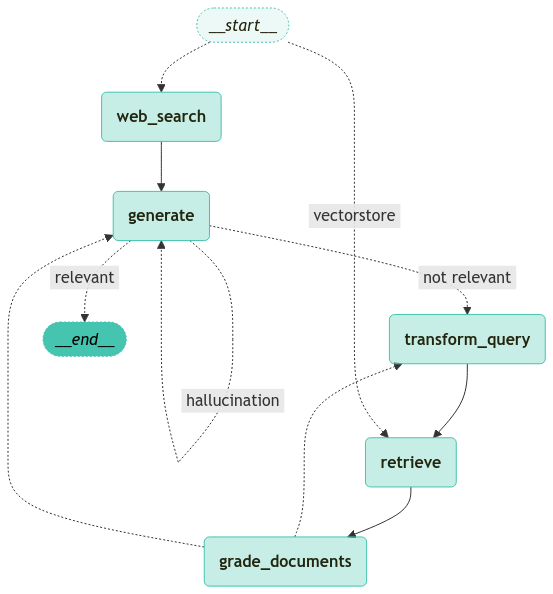

In [30]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(app)

[NOTE] Description
<div style="text-align: center;">
    <img src="./assets/07-langgraph-adaptive-rag-02.png" alt="Image Description" width="500">
</div>

Here's an explanation of the diagram based on the **Graph Compilation** context:

This diagram represents an **Adaptive RAG** (Retrieval-Augmented Generation) workflow, showing how nodes and edges are connected in the query processing flow:

1. **Node Definition**:
   - `_start_` and `_end_` define entry and exit states
   - `web_search` handles web-based information retrieval
   - `Generate` manages content generation
   - `transform_query` processes and adapts queries
   - `retrieve` fetches relevant information
   - `grade_documents` evaluates document quality
   - `vectorstore` manages vector-based information storage

2. **Edge Configuration**:
   - Solid arrows represent direct transitions between nodes
   - Dashed arrows indicate conditional paths and feedback loops
   - Labels like 'not relevant', 'hallucination', and 'relevant' define transition conditions

3. **Workflow Construction**:
   - Primary path splits into web search and vector retrieval branches
   - Multiple feedback loops ensure quality control
   - Integration between retrieval (`web_search`, `retrieve`) and generation (`Generate`) components
   - Document grading system (`grade_documents`) provides quality assurance

## Graph Utilization

In the **Graph Utilization** stage, the execution of **Adaptive RAG** is used to verify query processing results. This process follows the nodes and edges of the graph to generate the final outcome.

* **Graph Execution** : Execute the defined graph by following the query's flow.
* **Result Verification** : Review the generated results after graph execution to confirm that the query was processed appropriately.
* **Result Analysis** : Analyze the generated results to evaluate their alignment with the query's objectives.

In [31]:
from langchain_opentutorial.messages import stream_graph
from langchain_core.runnables import RunnableConfig
import uuid

# Configure settings (maximum recursion, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": uuid.uuid4()})

# Input question
inputs = {
   "question": "What are the current limitations of AI applications in healthcare settings as outlined by the European approach?",
}

# Execute graph
stream_graph(app, inputs, config, ["agent", "rewrite", "generate"])

==== [ROUTE QUESTION] ====
==== [ROUTE QUESTION TO VECTORSTORE] ====
==== [RETRIEVE] ====
==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
==== [DECISION TO GENERATE] ====
==== [DECISION: GENERATE] ====
==== [GENERATE] ====

🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
AI applications in healthcare face several limitations according to the European approach:

1. **Data Privacy and Security**: There are significant concerns about data privacy and patient trust, especially regarding the use of personal health data. AI tools need to demonstrate that they handle data privacy with extra care beyond GDPR requirements.

2. **Data Fragmentation**: The fragmented nature of European healthcare systems and standards poses challenges for data access and interoperability across different regions and institutions.

3. **Organizational and Skill Chal